In [1]:
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

In [2]:
IMAGE_SIZE=128
BATCH_SIZE = 128
FOLDER = "Donnee_DP_moitié_Autre"
# create generator
datagen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             horizontal_flip=True,
                             rotation_range=15,
                             zoom_range=0.5)
datagen_val = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset
train = datagen.flow_from_directory(os.path.join(FOLDER,'train'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse", color_mode="rgb", batch_size=BATCH_SIZE)
val = datagen_val.flow_from_directory(os.path.join(FOLDER,'val'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)
# confirm the iterator works
batchX, batchy = train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 3956 images belonging to 2 classes.
Found 493 images belonging to 2 classes.
Batch shape=(128, 128, 128, 3), min=0.000, max=0.945


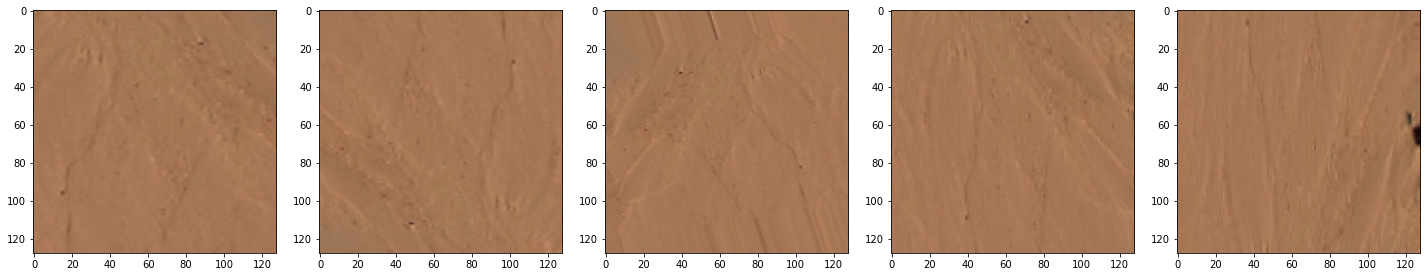

In [3]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train[0][0][5] for i in range(5)]
plotImages(augmented_images)

In [4]:
NUM_CLASSES=2

In [5]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [6]:
from tensorflow.keras.applications import ResNet50

In [7]:
def build_resnet():
    model = ResNet50(include_top=True, weights=None, classes=NUM_CLASSES)
    return model

In [8]:
#model = build_model()
model = build_resnet()

METRICS = ["accuracy"]
    
model.compile(
        optimizer='adam',
        loss= tf.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
)

In [9]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(FOLDER+"_model_avec_DA_Conta_Autre_2500.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

In [11]:
history = model.fit(
    train,
    validation_data=val,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 4 steps
Epoch 1/100
31/31 [==============================] - 52s 2s/step - loss: 2.2589 - accuracy: 0.5938 - val_loss: 2867950050607104.0000 - val_accuracy: 0.6471
Epoch 2/100
31/31 [==============================] - 43s 1s/step - loss: 0.6725 - accuracy: 0.6451 - val_loss: 148467672.0000 - val_accuracy: 0.6471
Epoch 3/100
31/31 [==============================] - 42s 1s/step - loss: 0.7540 - accuracy: 0.6385 - val_loss: 127.2253 - val_accuracy: 0.6471
Epoch 4/100
31/31 [==============================] - 42s 1s/step - loss: 0.6700 - accuracy: 0.6413 - val_loss: 24.2538 - val_accuracy: 0.6369
Epoch 5/100
31/31 [==============================] - 42s 1s/step - loss: 0.6633 - accuracy: 0.6362 - val_loss: 15.2787 - val_accuracy: 0.6369
Epoch 6/100
31/31 [==============================] - 43s 1s/step - loss: 0.6321 - accuracy: 0.6373 - val_loss: 1.6016 - val_accuracy: 0.6491
Epoch 7/100
31/31 [=================

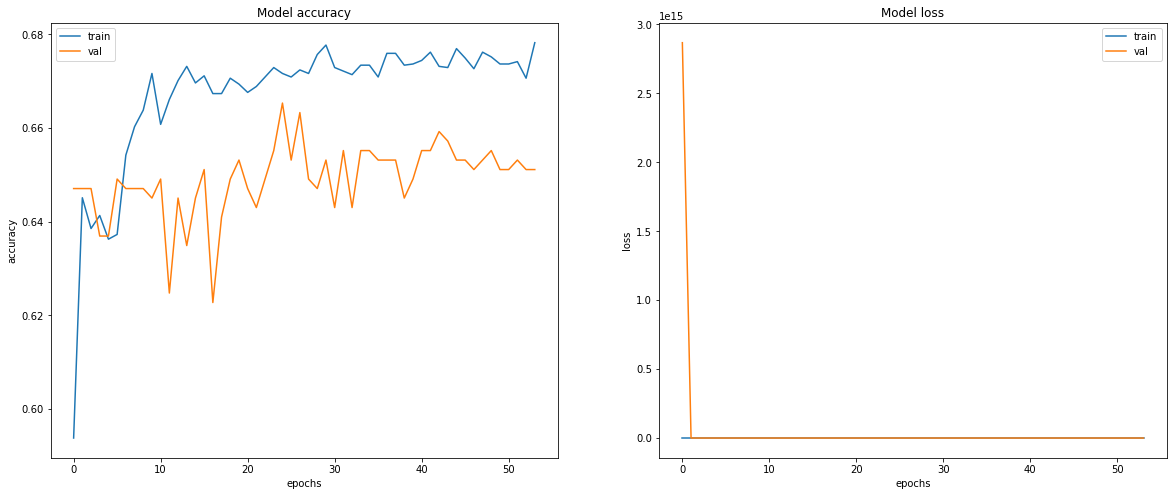

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [13]:
datagen_test = ImageDataGenerator(rescale=1./255)

test = datagen.flow_from_directory(os.path.join(FOLDER,'test'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)

Found 496 images belonging to 2 classes.


In [17]:
model_sans_DA = tf.keras.models.load_model("Donnee_DP_moitié_Autre_model_avec_DA_Conta_Autre_2500.h5")

In [18]:
_ = model_sans_DA.evaluate(test)

  ...
    to  
  ['...']
4/4 [==============================] - 7s 2s/step - loss: 0.6024 - accuracy: 0.6633
